<h2> LR, linearSVM on tfidf + other features </h2>

In [1]:


# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
# data slicing before featurization to avoid data leakage problem.

data_train = df[:70000] 
data_test = df[70000:100000]

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
id              70000 non-null int64
qid1            70000 non-null int64
qid2            70000 non-null int64
question1       70000 non-null object
question2       70000 non-null object
is_duplicate    70000 non-null int64
dtypes: int64(4), object(2)
memory usage: 3.2+ MB


In [7]:
questions_tr = list(data_train['question1']) + list(data_train['question2'])
questions_te = list(data_test['question1']) + list(data_test['question2'])


In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(lowercase=False,)

train_tf_idf = tf_idf_vect.fit_transform(questions_tr)
test_tf_idf = tf_idf_vect.transform(questions_te)

In [9]:
train_tf_idf[70000:140000].shape

(70000, 47838)

In [10]:
len(tf_idf_vect.get_feature_names())

47838

In [11]:
from scipy.sparse import hstack , vstack
# using hstack to put Q1 & Q2 together adjacent to one other 
tfidf_q1q2_train = hstack((train_tf_idf[:70000], train_tf_idf[70000:140000]))
tfidf_q1q2_test = hstack((test_tf_idf[:30000], train_tf_idf[30000:60000]))


In [12]:
tfidf_q1q2_train.shape , tfidf_q1q2_test.shape

((70000, 95676), (30000, 95676))

In [13]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
                    
                    

In [14]:
# class_label = df1['is_duplicate']
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
class_label = df1['is_duplicate']
df1 = df1.drop(['is_duplicate'], axis = 1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [15]:
# dataframe of nlp features
df1.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [16]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [17]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])

print("Number of features in new dataframe  :", df1.shape[1]+df2.shape[1])

Number of features in nlp dataframe : 16
Number of features in preprocessed dataframe : 12
Number of features in new dataframe  : 28


In [18]:
df_dense_feature  = df1.merge(df2, on='id',how='left')
df_dense_feature = df_dense_feature[:100000]
df_dense_feature = df_dense_feature.drop(['id'], axis= 1)
df_dense_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 26 columns):
cwc_min                 100000 non-null float64
cwc_max                 100000 non-null float64
csc_min                 100000 non-null float64
csc_max                 100000 non-null float64
ctc_min                 100000 non-null float64
ctc_max                 100000 non-null float64
last_word_eq            100000 non-null float64
first_word_eq           100000 non-null float64
abs_len_diff            100000 non-null float64
mean_len                100000 non-null float64
token_set_ratio         100000 non-null int64
token_sort_ratio        100000 non-null int64
fuzz_ratio              100000 non-null int64
fuzz_partial_ratio      100000 non-null int64
longest_substr_ratio    100000 non-null float64
freq_qid1               100000 non-null int64
freq_qid2               100000 non-null int64
q1len                   100000 non-null int64
q2len                   100000 non-null 

In [19]:
df_dense_feature.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [20]:
X_train = df_dense_feature.iloc[:70000, :].values
X_test = df_dense_feature.iloc[70000:, :].values



from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [38]:
# df_dense_feature = np.concatenate((X_train, X_test), axis=0)

In [39]:
# df_dense_feature.shape

(100000, 26)

In [37]:
df_sparse_features = vstack((tfidf_q1q2_train, tfidf_q1q2_test)) # combining single set with joining train
                                                        # & test set sparse matrices.

In [21]:
df_final_train = hstack((X_train , tfidf_q1q2_train )).tocsr()
df_final_test = hstack((X_test, tfidf_q1q2_test)).tocsr()
# Code to join sparse & dense matices .. . .  .

In [22]:
import scipy.sparse # saving matrices for future use 
scipy.sparse.save_npz('df_final_train.npz', df_final_train)
scipy.sparse.save_npz('df_final_test.npz', df_final_test)

In [42]:
# df = scipy.sparse.load_npz('tfidf_final.npz') #loading matrices

In [25]:
X_train = df_final_train[:, :]
X_test = df_final_test[:, :]
y_train = class_label[:70000]
y_test = class_label[70000:100000]
# train and test set formation . . . . 

In [26]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((70000, 95702), (70000,), (30000, 95702), (30000,))

In [27]:
from collections import Counter

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6275428571428572 Class 1:  0.3724571428571429
---------- Distribution of output variable in train data ----------
Class 0:  0.37273333333333336 Class 1:  0.37273333333333336


In [28]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Random Model

Log loss on Test Data using Random Model 0.8915791639556566


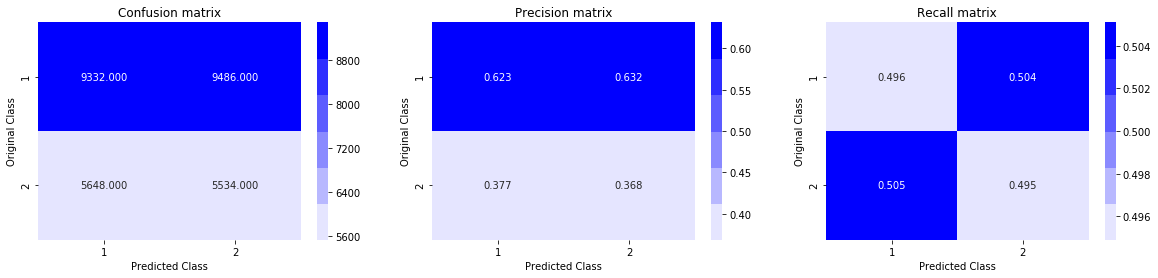

In [29]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.42713213456155885
For values of alpha =  0.0001 The log loss is: 0.4133060802503807
For values of alpha =  0.001 The log loss is: 0.41125599337774765
For values of alpha =  0.01 The log loss is: 0.42669416430618623
For values of alpha =  0.1 The log loss is: 0.46930259353449333
For values of alpha =  1 The log loss is: 0.5144774837134626
For values of alpha =  10 The log loss is: 0.5357899428273287
For values of alpha =  100 The log loss is: 0.5396382633282673
For values of alpha =  1000 The log loss is: 0.5400596384226751
For values of best alpha =  0.001 The train log loss is: 0.3974778053130938
For values of best alpha =  0.001 The test log loss is: 0.4114086962596874
Total number of data points : 30000


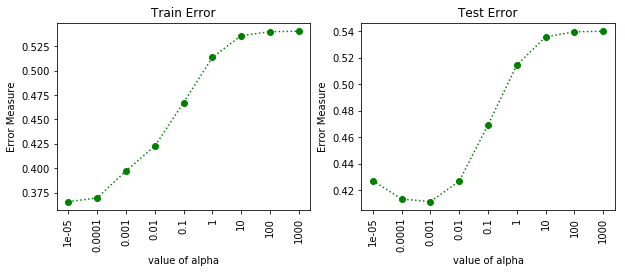

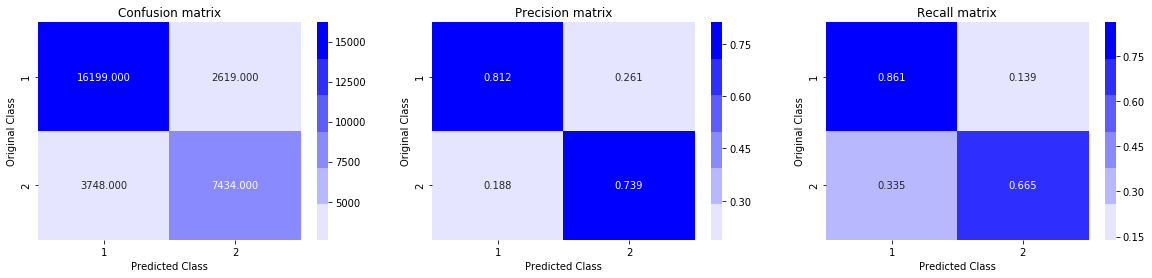

In [33]:
alpha = [10 ** x for x in range(-5, 4)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

alpha_label = [str(a) for a in alpha]
log_error_array=[]
log_error_array_tr = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight = 'balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    predict_y_tr = sig_clf.predict_proba(X_train)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    log_error_array_tr.append(log_loss(y_train, predict_y_tr, labels=clf.classes_, eps=1e-15))
#     error_score = [log_error_array_tr,log_error_array]
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


error_score = [log_error_array_tr,log_error_array]

f = plt.figure(figsize=(10,20))

#
title_ = ['Train Error' , 'Test Error']
ax ={}
for x in range(1,3):
    ax['ax{0}'.format(x)] = f.add_subplot(5,2,x)
    plt.xticks(rotation=90)
    plt.xlabel('value of alpha')
    plt.ylabel('Error Measure')
for i in range(1,3):

    ax['ax'+ str(i)].title.set_text(title_[i-1])

    ax['ax'+ str(i)].plot(alpha_label, error_score[i-1] , 'go:' , )


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear-SVM

For values of alpha =  1e-05 The log loss is: 0.4424520340411049
For values of alpha =  0.0001 The log loss is: 0.41858112666027747
For values of alpha =  0.001 The log loss is: 0.4178972449098092
For values of alpha =  0.01 The log loss is: 0.42990555151705573
For values of alpha =  0.1 The log loss is: 0.4936592269672528
For values of alpha =  1 The log loss is: 0.6603945604266559
For values of alpha =  10 The log loss is: 0.6603945604266559
For values of alpha =  100 The log loss is: 0.6603945604266559
For values of best alpha =  0.001 The train log loss is: 0.4159021005155427
For values of best alpha =  0.001 The test log loss is: 0.41931929101487464
Total number of data points : 30000


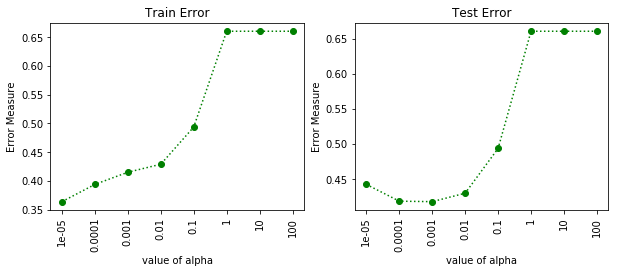

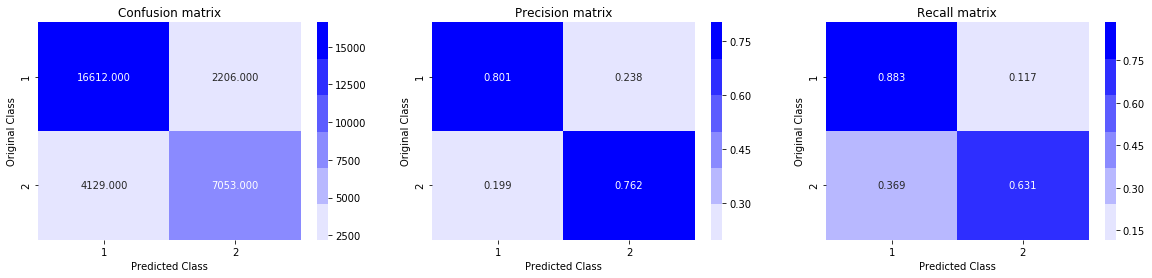

In [56]:
alpha = [10 ** x for x in range(-5, 3)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

alpha_label = [str(a) for a in alpha]

log_error_array=[]
log_error_array_tr = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight = 'balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    predict_y_tr = sig_clf.predict_proba(X_train)
    
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    log_error_array_tr.append(log_loss(y_train, predict_y_tr, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

error_score = [log_error_array_tr,log_error_array]

f = plt.figure(figsize=(10,20))

#
title_ = ['Train Error' , 'Test Error']
ax ={}
for x in range(1,3):
    ax['ax{0}'.format(x)] = f.add_subplot(5,2,x)
    plt.xticks(rotation=90)
    plt.xlabel('value of alpha')
    plt.ylabel('Error Measure')
for i in range(1,3):

    ax['ax'+ str(i)].title.set_text(title_[i-1])

    ax['ax'+ str(i)].plot(alpha_label, error_score[i-1] , 'go:' , )



best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Results & Conclusion 

In [35]:
from prettytable import PrettyTable
summ = PrettyTable()

column_names = ["Parameter", "Logistic_reg", "L-SVM"]
summ.add_column(column_names[0],['alpha' , 'featurization', 'train_loss', 'test_loss', 'recall_class1'
                                , 'recall_class2'] )
summ.add_column(column_names[1], ['0.001','tfidf', '0.3974', '0.4114', '0.83', '0.661'])
summ.add_column(column_names[2],['0.001','tfidf', '0.4159', '0.4193', '0.88', '0.631'] )
# l1_.add_column(column_names[3], [])
print(summ)

+---------------+--------------+--------+
|   Parameter   | Logistic_reg | L-SVM  |
+---------------+--------------+--------+
|     alpha     |    0.001     | 0.001  |
| featurization |    tfidf     | tfidf  |
|   train_loss  |    0.3974    | 0.4159 |
|   test_loss   |    0.4114    | 0.4193 |
| recall_class1 |     0.83     |  0.88  |
| recall_class2 |    0.661     | 0.631  |
+---------------+--------------+--------+


## Conclusion:
    
    - tfidf works well with both algorithms i.e. logistic regression & L-svm, since data now is in very high dimension.
    - Earlier both models seems biased towards class 1 when default class weights is used during model training as recall value for class 1 is above 0.9 but for class 2 it is 0.5.
    - When class_weights = 'balanced' is used for both models, new recall values comes 0.88 & 0.66 for model 1 for both classes and almost similar result for model 2 which is a sign of impromance.
    

    Note: As stated in comment section of assignment video about data leakage problem, its taken care of as data slicing done before featurizing data